The goal of our project is to study and identify the relationships between the initial budget and subsequent imdb user rating, metascore critics rating, box office receipts and the number of nominations and awards.

Stages of the study completed:
- Data collection, data parsing from the imdb website
- Data cleaning, processing and preparation

At this stage, we will analyze the data obtained and try to visualize the results

In [1]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
import pandas as pd
import plotly.express as px
from collections import Counter

Let's start with the graph below.

In this graph, we see a clear dependence of box office receipts on the initial budget. Films above the red line have box office receipts higher than the budget allocated for their filming.

It is clear from the graph that as the budget increases, so do box office receipts, which in turn are one of the indicators of the film's quality.

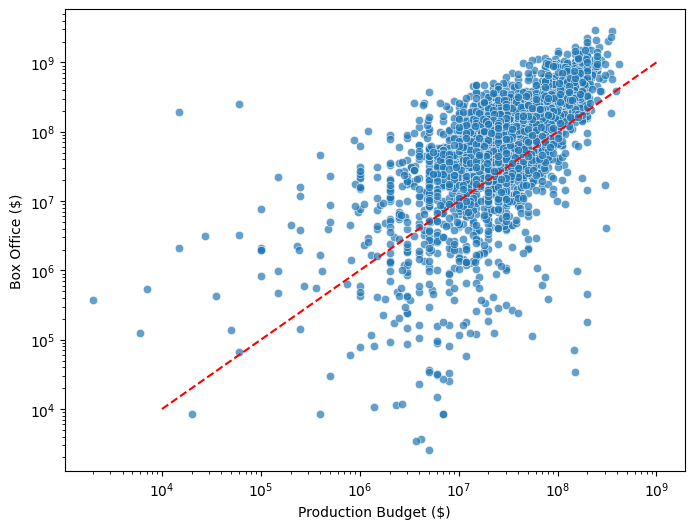

In [2]:
with open("data/films_metascore_unknown.json", "r", encoding="utf-8") as f:
    films = json.load(f)

budgets = []
box_offices = []

for film in films:
    if film["production_budget"] and film["box_office"]:
        budgets.append(film["production_budget"])
        box_offices.append(film["box_office"])

plt.figure(figsize=(8, 6))
sns.scatterplot(x=budgets, y=box_offices, alpha=0.7)

# Add reference line (budget = box office)
x_vals = np.logspace(4, 9, 100)  # Avoid 0; start from 10^6 to 10^9
plt.plot(x_vals, x_vals, linestyle="--", color="red", label="Break-even line")

plt.xlabel("Production Budget ($)")
plt.ylabel("Box Office ($)")
plt.xscale("log")  # Use scale for better display
plt.yscale("log")
plt.show()

Next, we will build the same dependence but add the IMDB rating and metascore rating to it. Here we can notice 2 things:

1. Despite the fact that the medians of the green and blue groups (with high ratings) are higher than, for example, the indicators of the red or orange group (with low ratings), the dependence of ratings on the budget or box office receipts cannot be called linear.

2. The IMDB rating does not quite correctly show the real quality of the film. In comparing the graphs, we see that the IMDB graph in comparison with the metascore opinion does not have a normal distribution and is concentrated in the region of 6 - 8 points. This indicates that ordinary viewers are not inclined to give too low or too high ratings to films, even if their impressions correspond to them.

In [3]:
# Load data
with open("data/films_metascore_unknown.json", "r", encoding="utf-8") as f:
    films = json.load(f)

# Prepare data
data = []
for film in films:
    if film["production_budget"] and film["box_office"] and film["imdb"] and film["metascore"]:
        data.append({
            "title": film["title"],
            "budget": film["production_budget"],
            "box_office": film["box_office"],
            "imdb": round(film["imdb"]),
            "metascore": round(film["metascore"] // 10) * 10
        })

df = pd.DataFrame(data)

# Define colors for IMDb-based plot (HEX colors)
def imdb_color(imdb_score):
    if imdb_score < 3.5:
        return "< 3.5"  # Red
    elif imdb_score < 5.5:
        return "< 5.5"  # Orange
    elif imdb_score < 6.5:
        return "< 6.5"  # Yellow
    elif imdb_score < 7.5:
        return "< 7.5"  # DodgerBlue
    else:
        return ">= 7.5"  # Green

df["imdb_color"] = df["imdb"].apply(imdb_color)

# Define colors for Metascore-based plot (HEX colors)
def metascore_color(metascore):
    if metascore < 35:
        return "< 35"  # Red
    elif metascore < 55:
        return "< 55"  # Orange
    elif metascore < 65:
        return "< 65"  # Yellow
    elif metascore < 75:
        return "< 75"  # DodgerBlue
    else:
        return ">= 75"  # Green

df["metascore_color"] = df["metascore"].apply(metascore_color)

# --- IMDb-based dot plot ---
fig1 = px.scatter(
    df, x="budget", y="box_office",
    size="imdb", color="imdb_color",
    hover_name="title",
    marginal_x="rug",
    marginal_y="rug",
    title="Box Office vs Production Budget (IMDb-based)",
    log_x=True, log_y=True,
    color_discrete_map={
        "< 3.5": "Red",
        "< 5.5": "Orange",
        "< 6.5": "Yellow",
        "< 7.5": "Blue",
        ">= 7.5": "Green"
    }
)
fig1.update_layout(height=800)
fig1.show()

# --- Metascore-based dot plot ---
fig2 = px.scatter(
    df, x="budget", y="box_office",
    size="metascore", color="metascore_color",
    hover_name="title",
    marginal_x="rug",
    marginal_y="rug",
    title="Box Office vs Production Budget (Metascore-based)",
    log_x=True, log_y=True,
    color_discrete_map={
        "< 35": "Red",
        "< 55": "Orange",
        "< 65": "Yellow",
        "< 75": "Blue",
        ">= 75": "Green"
    }
)
fig2.update_layout(height=800)
fig2.show()


To confirm conclusion number 2 from the previous graph, we will construct a rating distribution diagram in different genres. By comparing the graphs for IMDB and metascore, we confirm our hypothesis and come to the conclusion that it is not entirely correct to rely on the imdb rating to determine the quality of a film.

In [4]:
with open("data/films_metascore_unknown.json", "r", encoding="utf-8") as f:
    films = json.load(f)

genre_counter = Counter()
for film in films:
    if "genres" in film:
        genre_counter.update(film["genres"])

top_10_genres = {genre for genre, _ in genre_counter.most_common(10)}

data = []
for film in films:
    if "genres" in film and film["imdb"] and film["metascore"]:
        imdb_rounded = round(film["imdb"] * 2) / 2
        metascore_rounded = round(film["metascore"] / 5) * 5
        for genre in film["genres"]:
            if genre in top_10_genres:
                data.append({"genre": genre, "imdb": imdb_rounded, "metascore": metascore_rounded})

df = pd.DataFrame(data)

fig1 = px.histogram(df,
                    x="imdb",
                    animation_frame="genre",
                    title="IMDb rating distribution by genre",
                    labels={"imdb": "IMDb", "genre": "Genre"},
                    template="plotly_dark",
                    color_discrete_sequence=["lightblue"])

fig1.update_layout(xaxis_title="IMDb", yaxis_title="Number of films", title_font_size=20, font=dict(size=14))
fig1.show()

fig2 = px.histogram(df,
                    x="metascore",
                    animation_frame="genre",
                    title="Metascore distribution by genre",
                    labels={"metascore": "Metascore", "genre": "Genre"},
                    template="plotly_dark",
                    color_discrete_sequence=["orange"])

fig2.update_layout(xaxis_title="Metascore", yaxis_title="Number of films", title_font_size=20, font=dict(size=14))
fig2.show()


This graph shows the relationship between IMDb rating, Metascore, and the number of award nominations for movies in the database

The color of the dot reflects the financial success of the movie, comparing box_office and budget:

🔴 Red - the movie did not recoup its budget (box_office < budget).

🟠 Orange - the movie recouped, but not more than 2 times (budget ≤ box_office < 2 * budget).

🟢 Green - the movie collected more than 2 times its budget (box_office ≥ 2 * budget).

From the graph we can see that:
- Since the dots lie along the diagonal, it means that the audience and critics' ratings are correlated, but the scattered nature of the graph shows that this correlation is weak.
- Movies with a large number of nominations have a high rating, but there is no inverse relationship. This dependence is also weak
- The greatest number of nominations are for films with high profitability. Unlike the rating, profitability shows the success of a film almost linearly. Films with small box office receipts receive fewer awards.

In [5]:
with open("data/films_all_known.json", "r", encoding="utf-8") as f:
    films = json.load(f)

data = []
for film in films:
    if film["imdb"] and film["metascore"] and film["num_of_nominations"] and film["production_budget"] and film["box_office"]:
        budget = film["production_budget"]
        box_office = film["box_office"]

        if box_office < budget:
            color = "1. Box Office < Budget"
        elif budget <= box_office < 2 * budget:
            color = "2. Box Office ~ Budget (x2)"
        else:
            color = "3. Box Office >> Budget (x2+)"

        data.append({
            "title": film["title"],
            "imdb": film["imdb"],
            "metascore": film["metascore"],
            "num_of_nominations": film["num_of_nominations"],
            "color": color
        })

df = pd.DataFrame(data)

fig = px.scatter_matrix(df,
                        dimensions=["imdb", "metascore", "num_of_nominations"],
                        color="color",
                        title="Scatter Matrix: IMDb, Metascore, Nominations",
                        color_discrete_map={
                            "1. Box Office < Budget": "red",
                            "2. Box Office ~ Budget (x2)": "orange",
                            "3. Box Office >> Budget (x2+)": "green"
                        }
                       )

fig.show()


The next stage: studying the obtained results, explaining the found relationships based on additional parameters. Based on the results of the passed stage, we assume the possible influence of the cast or other additional criteria on the results. Therefore, we set ourselves the goal of testing this hypothesis

Next we will build graphs to show relationships with cast influence.

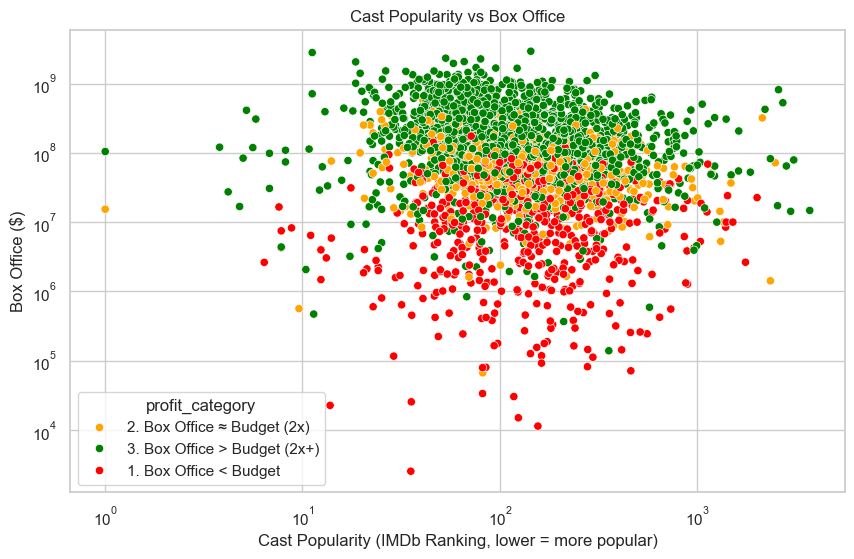

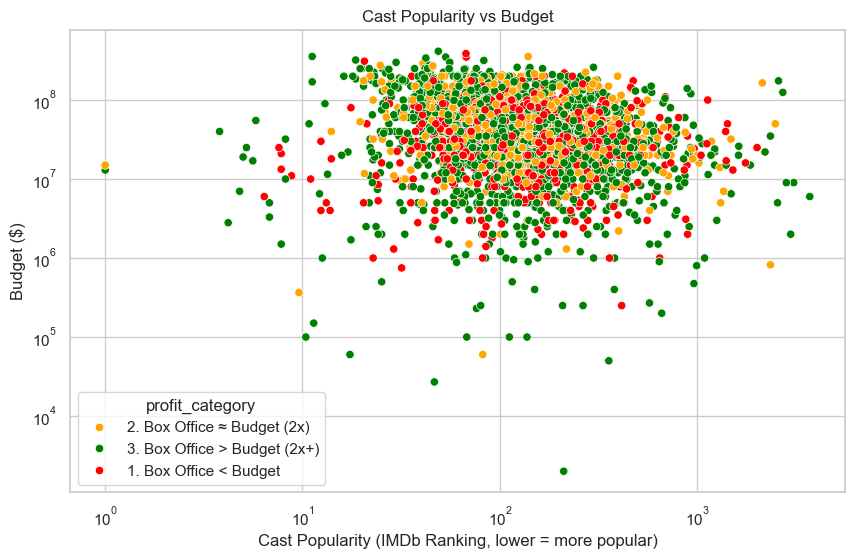

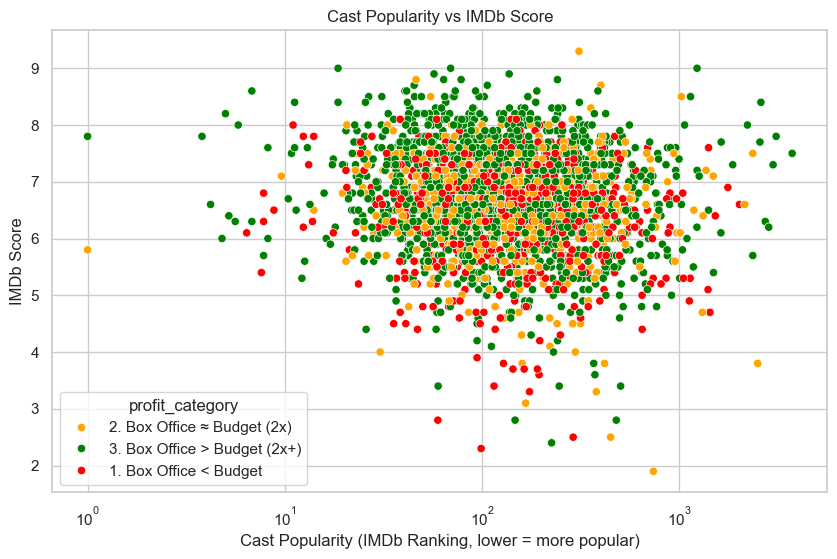

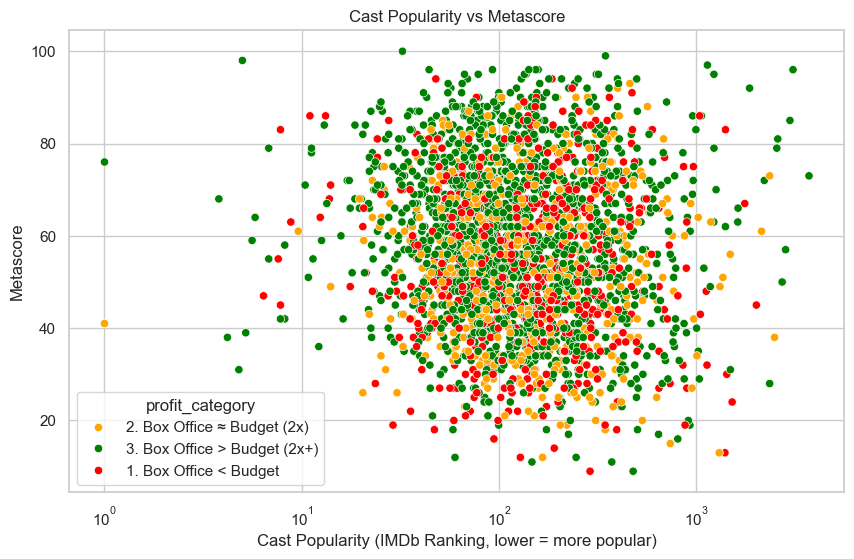

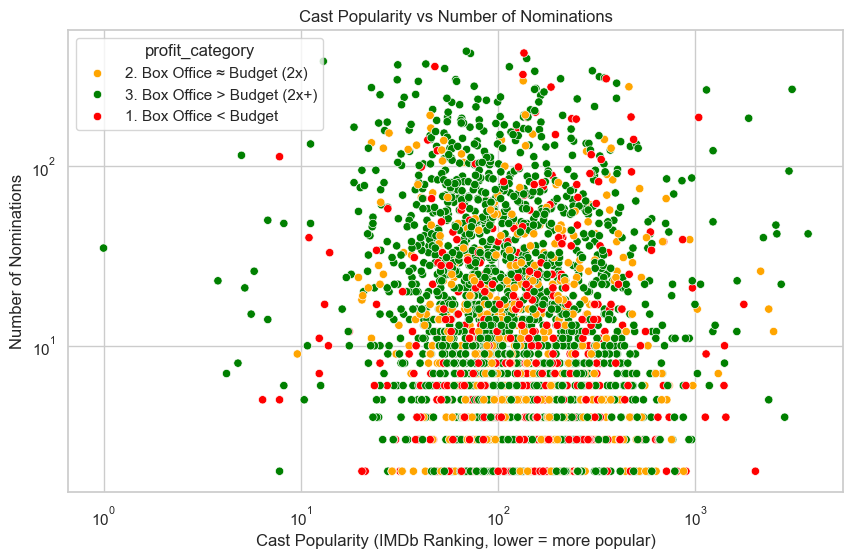

Correlation Matrix:
                    production_budget  box_office      imdb  metascore  \
production_budget            1.000000    0.692526  0.004045  -0.029498   
box_office                   0.692526    1.000000  0.187174   0.128444   
imdb                         0.004045    0.187174  1.000000   0.723066   
metascore                   -0.029498    0.128444  0.723066   1.000000   
num_of_nominations           0.127652    0.255290  0.426819   0.540448   
cast_popularity             -0.146306   -0.117317 -0.062128  -0.032043   

                    num_of_nominations  cast_popularity  
production_budget             0.127652        -0.146306  
box_office                    0.255290        -0.117317  
imdb                          0.426819        -0.062128  
metascore                     0.540448        -0.032043  
num_of_nominations            1.000000        -0.030222  
cast_popularity              -0.030222         1.000000  


In [33]:
data = pd.DataFrame(films.copy())

# Function to calculate mean actor cast popularity
def calculate_cast_popularity(cast_list):
    if not cast_list:
        return np.nan
    # Extract actors rankings (less - more popular)
    rankings = []
    for actor in cast_list:
        ranking = actor.get('popularity', None)  
        if ranking != 0:
            rankings.append(ranking)
        else:
            rankings.append(1000000)  # For actors with null choose very big number
    if not rankings:
        return np.nan
    # Take mean of 5 most popular actors of the cast
    rankings.sort()
    cast_rank = []
    for rank in rankings:
        if rank != 1000000:
            cast_rank.append(rank)
        if len(cast_rank) == 5:
            break

    return sum(cast_rank)/5

# Define cast popularity
data['cast_popularity'] = data['actors'].apply(calculate_cast_popularity)

# Define profit category
def categorize_profit(row):
    if pd.isna(row['box_office']) or pd.isna(row['production_budget']):
        return np.nan
    if row['box_office'] < row['production_budget']:
        return '1. Box Office < Budget'
    elif row['box_office'] <= row['production_budget'] * 2:
        return '2. Box Office ≈ Budget (2x)'
    else:
        return '3. Box Office > Budget (2x+)'

data['profit_category'] = data.apply(categorize_profit, axis=1)



sns.set(style="whitegrid")
custom_palette = {
    '1. Box Office < Budget': '#FF0000',           # Red
    '2. Box Office ≈ Budget (2x)': '#FFA500',  # Orange
    '3. Box Office > Budget (2x+)': '#008000'         # Green
}

# Plot 1: Cast Popularity vs Box Office
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='cast_popularity', y='box_office', hue='profit_category', palette=custom_palette)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Cast Popularity (IMDb Ranking, lower = more popular)')
plt.ylabel('Box Office ($)')
plt.title('Cast Popularity vs Box Office')
plt.show()

# Plot 2: Cast Popularity vs Budget
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='cast_popularity', y='production_budget', hue='profit_category', palette=custom_palette)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Cast Popularity (IMDb Ranking, lower = more popular)')
plt.ylabel('Budget ($)')
plt.title('Cast Popularity vs Budget')
plt.show()


# Plot 3: Cast Popularity vs IMDB Rating
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='cast_popularity', y='imdb', hue='profit_category', palette=custom_palette)
plt.xscale('log')
plt.xlabel('Cast Popularity (IMDb Ranking, lower = more popular)')
plt.ylabel('IMDb Score')
plt.title('Cast Popularity vs IMDb Score')
plt.show()


# Plot 4: Cast Popularity vs MetaScore
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='cast_popularity', y='metascore', hue='profit_category', palette=custom_palette)
plt.xscale('log')
plt.xlabel('Cast Popularity (IMDb Ranking, lower = more popular)')
plt.ylabel('Metascore')
plt.title('Cast Popularity vs Metascore')
plt.show()


# Plot 5: Cast Popularity vs Number of Nominations
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='cast_popularity', y='num_of_nominations', hue='profit_category', palette=custom_palette)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Cast Popularity (IMDb Ranking, lower = more popular)')
plt.ylabel('Number of Nominations')
plt.title('Cast Popularity vs Number of Nominations')
plt.show()


# Correlations
correlation_matrix = data[['production_budget', 'box_office', 'imdb', 'metascore', 'num_of_nominations', 'cast_popularity']].corr()
print("Correlation Matrix:")
print(correlation_matrix)

### Insights from Plots
No clear trend emerges, with points widely dispersed. Therefore, we can conclude that cast popularity has negligible impact on overall film success.

**Image 1 (vs. Box Office):** No clear trend; points scatter widely from 10^4 to 10^9 box office and 10^0 to 10^2 cast popularity. Green dots (high profit) cluster at higher earnings, but yellow and red dots are present across all levels, supporting the weak correlation (-0.117317).

**Image 2 (vs. Budget):** Scattered distribution with no strong trend; budgets range from 10^4 to 10^8, with green dots dominant in mid-to-high ranges, aligning with the weak negative correlation (-0.146306).

**Image 3 (vs. IMDb):** Points cluster at IMDb 5–7 and cast popularity 10^0 - 10^2, with no clear trend, supporting the weak correlation (-0.062128). Profit categories are mixed across ratings.

**Image 4 (vs. Metascore):** Similar scattering (Metascore 40–80, cast popularity 10^0 - 10^2), with no trend, confirming the weak correlation (-0.032043).
**Image 5 (vs. Nominations):** No clear pattern; nominations range from 10^0 to 10^2, with green points slightly more at higher counts, but the weak correlation (-0.030222) holds.

### Key Insights from Correlation Matrix

- **Production Budget and Box Office:** A strong positive correlation (0.6925) indicates that higher budgets are often associated with higher box office earnings, though profitability depends on the profit category.

- **IMDb and Metascore:** A strong correlation (0.7231) suggests that audience ratings (IMDb) align closely with critical reviews (Metascore).

- **Number of Nominations:** Moderate correlations with IMDb (0.4268) and Metascore (0.5404) imply that critically acclaimed films are more likely to receive nominations.

- **Cast Popularity:** Exhibits weak negative correlations with all other variables (e.g., -0.117317 with box office, -0.062128 with IMDb), suggesting that higher cast popularity (lower IMDb ranking) has minimal impact on financial success, ratings, or nominations.

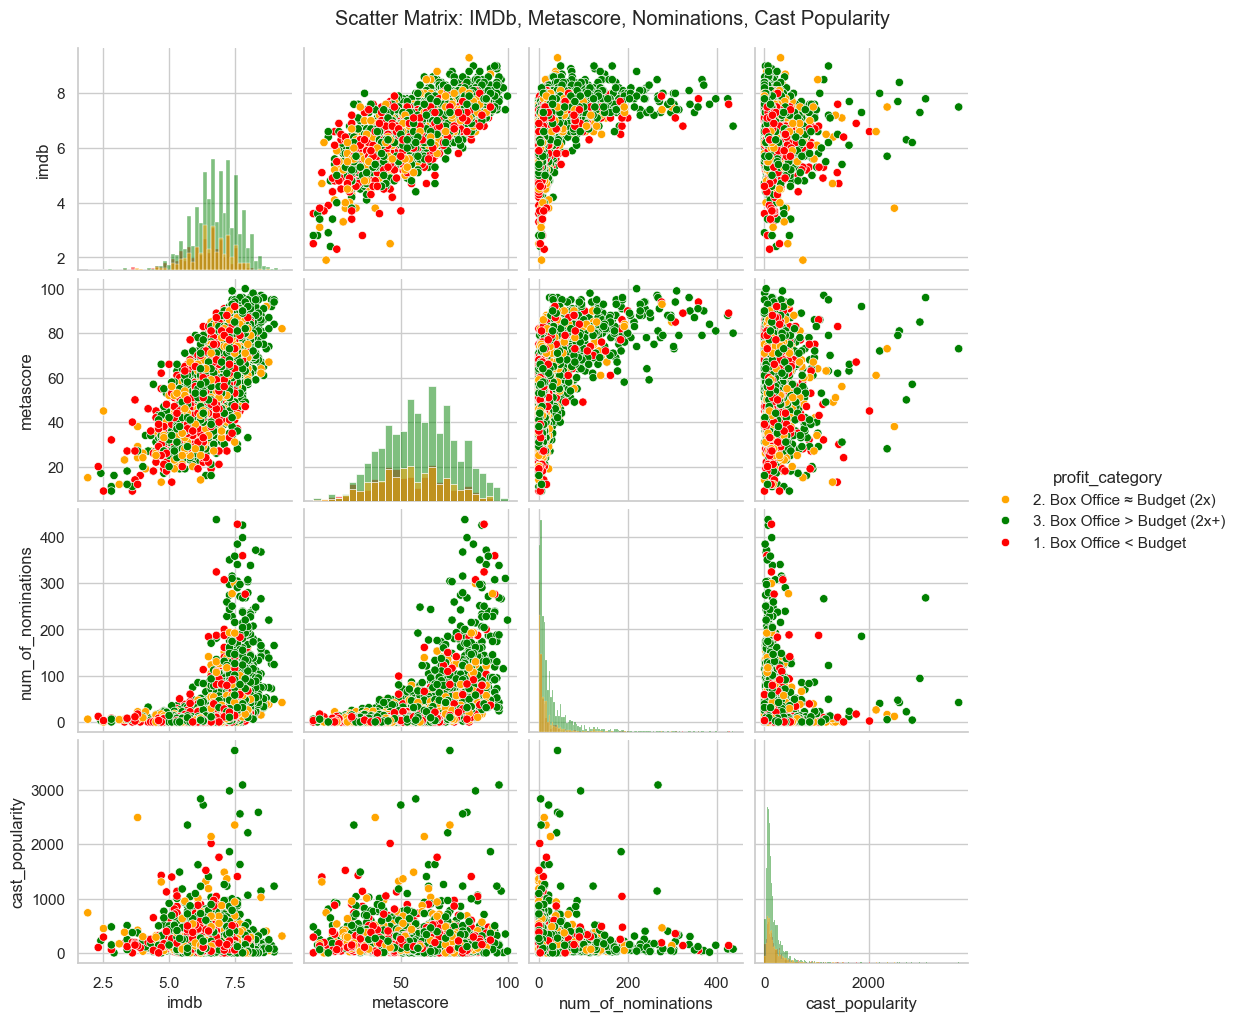

In [34]:
# Final Scatter Matrix
scatter_data = data[['imdb', 'metascore', 'num_of_nominations', 'cast_popularity', 'profit_category']]
sns.pairplot(scatter_data, hue='profit_category', palette=custom_palette, diag_kind='hist')
plt.suptitle('Scatter Matrix: IMDb, Metascore, Nominations, Cast Popularity', y=1.02)
plt.show()


### General Findings
- **Financial Performance:**
The strong production budget–box office correlation (0.692526) is a key driver, with scatter plots showing higher budgets leading to higher earnings, though profitability varies (green dots for >2x budget dominate high box office ranges).
Cast popularity has little influence (-0.117317), as profitable films span all popularity levels.

- **Critical Success:**
IMDb and Metascore’s strong correlation (0.723066) is evident in tight scatter trends, with high ratings linked to more nominations (0.426819 and 0.540448).
Cast popularity shows no significant effect (-0.062128 with IMDb, -0.032043 with Metascore), as ratings are consistent across popularity ranges.

- **Award Recognition:**
Moderate correlations with IMDb, Metascore, and box office (0.255290) suggest nominations are tied to quality and success, visually supported by green dots at higher nomination counts.
Cast popularity’s negligible correlation (-0.030222) is confirmed by scattered points across nomination ranges.

- **Profit Categories:**
Green dots (Box Office > Budget 2x+) often align with higher box office, IMDb, Metascore, and nominations, indicating successful films excel across multiple metrics.
Red dots (Box Office < Budget) are more common at lower values, while yellow dots (Box Office ≈ Budget 2x) bridge the gap, showing moderate success.